# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [4]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 20.9 s, sys: 124 ms, total: 21 s
Wall time: 6.51 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [14]:
# X = df_train_features_extended.values
# y = df_train_targets["radiant_win"].values.astype("int8")

# model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1,random_state=SEED, n_estimators=80)
# model.fit(df_train_features_extended.values, y,
#           verbose=20,eval_metric='logloss')

In [15]:
# df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
#                                    index_col="match_id_hash")

# X_test = df_test_features_2.values
# y_test_pred = model.predict_proba(X_test)[:, 1]

# df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
#                                  index=df_test_features.index)

In [16]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

In [17]:
# submission_filename = "submission_{}.csv".format(
#     datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
# df_submission.to_csv(submission_filename)
# print("Файл посылки сохранен, как: {}".format(submission_filename))

## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [19]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 4.51 s, sys: 581 ms, total: 5.09 s
Wall time: 35.7 s


In [20]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [21]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [23]:
match

{'game_time': 2049,
 'match_id_hash': '75112757bde649d5cff1c7cd4f1275c6',
 'teamfights': [{'start': 306.755,
   'end': 338.551,
   'last_death': 323.454,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
     'item_uses': {},
     'killed': {'npc_dota_hero_faceless_void': 114},
     'deaths': 0,
     'buybacks': 0,
     'damage': 383,
     'healing': 0,
     'gold_delta': 336,
     'xp_delta': 440},
    {'deaths_pos': {},
     'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
     'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 458,
     'healing': 0,
     'gold_delta': -10,
     'xp_delta': 76},
    {'deaths_pos': {},
     'ability_uses': {},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
     'healing': 0,
     'gold_delta': 174,
     'xp_delta': 249},
    {'deaths_pos': {},
     'abilit

In [24]:
match['teamfights'][1]['players'][1]

{'deaths_pos': {},
 'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 6},
 'item_uses': {},
 'killed': {},
 'deaths': 0,
 'buybacks': 0,
 'damage': 1107,
 'healing': 0,
 'gold_delta': -31,
 'xp_delta': 203}

In [25]:
match['teamfights'][1]['players'][1]['deaths']

0

In [26]:
r_tf_win = 0

for teamfight in match['teamfights']:
    r_tf_deaths = 0
    d_tf_deaths = 0
    counter = 1
    
    for player in teamfight['players']:
        if counter < 6:
            r_tf_deaths += player['deaths']
        else:
            d_tf_deaths += player['deaths']
        counter += 1
        
    if r_tf_deaths < d_tf_deaths:
        r_tf_win += 1
    elif r_tf_deaths > d_tf_deaths:
        r_tf_win -= 1

print(r_tf_win)
    

1


In [27]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [28]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

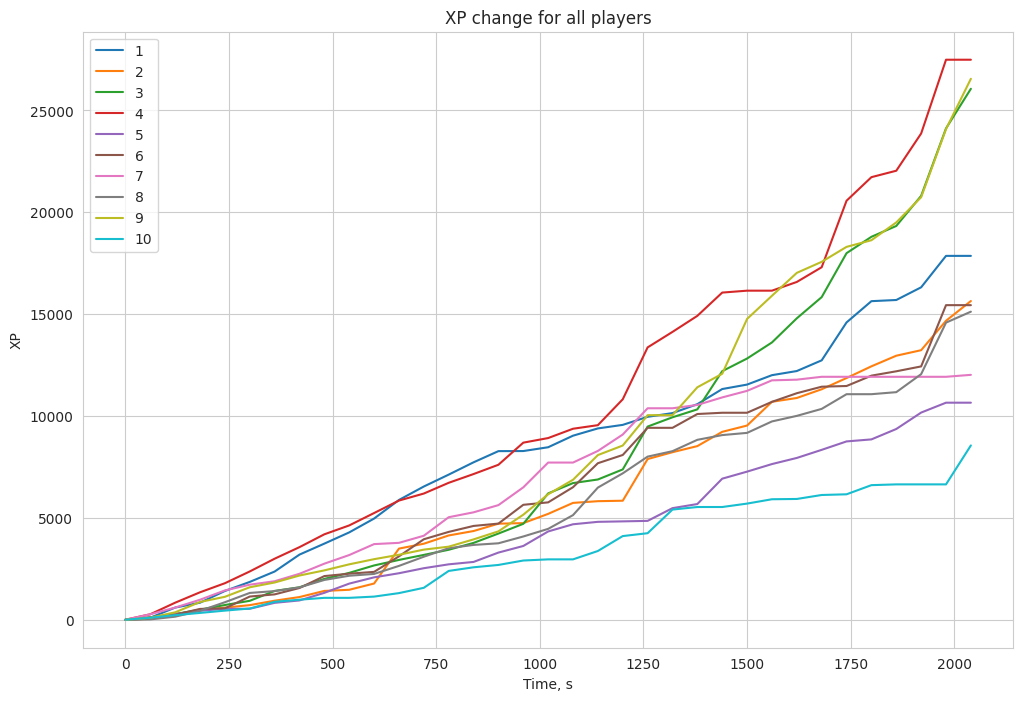

In [29]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [30]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [31]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

In [32]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        r_tf_win = 0
        
        
        # Ужасная, но таки полезная попытка посчитать количество разрушенных бараков
        
        radiant_bar_kills = 0
        dire_bar_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                if df_features.loc[match_id_hash, "diff_tower_kills"] > 0:
                    radiant_bar_kills += 1
                if df_features.loc[match_id_hash, "diff_tower_kills"] < 0:
                    dire_bar_kills += 1

        df_features.loc[match_id_hash, "radiant_bar_kills"] = radiant_bar_kills
        df_features.loc[match_id_hash, "dire_bar_kills"] = dire_bar_kills
        df_features.loc[match_id_hash, "diff_bar_kills"] = radiant_bar_kills - dire_bar_kills
        


        
        # Чаще ли свет побеждает в тимфантах (на тестовых данных бесполезно (через убийства тоже))
#         r_tf_win = 0

#         for teamfight in match['teamfights']:
#             r_gold_delta = 0
#             d_gold_delta = 0
#             counter = 1

#             for player in teamfight['players']:
#                 if counter < 6:
#                     r_gold_delta += player['gold_delta']
#                 else:
#                     d_gold_delta += player['gold_delta']
#                 counter += 1

#             if r_gold_delta > d_gold_delta:
#                 r_tf_win += 1
#             elif r_gold_delta < d_gold_delta:
#                 r_tf_win -= 1
            
#         df_features.loc[match_id_hash, "r_tf_win"] = r_tf_win

In [32]:
# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [33]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [34]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 61.5 ms, sys: 58.2 ms, total: 120 ms
Wall time: 1min


In [35]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7720210676055513


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

In [36]:
# считаем преимущество света простейшим образом

def simple_advantage(data, feature):
    data[f'r_adv_{feature}'] = 0
    c = 1
    while c < 11:
        if c < 6:
            data[f'r_adv_{feature}'] += data[f'r{c}_{feature}']
        else:
            data[f'r_adv_{feature}'] -= data[f'd{c - 5}_{feature}']
        c += 1

In [37]:
# функция для нахождения разницы между максимами двух команд для одной фичи

def find_max(data, feature):
    r = data[f'r1_{feature}']
    d = data[f'd1_{feature}'] 
    
    for i in range(2,6):
        r = np.where(data[f'r{i}_{feature}'] > r, data[f'r{i}_{feature}'], r)
        d = np.where(data[f'd{i}_{feature}'] > d, data[f'd{i}_{feature}'], d)
        r_adv_max_KDA = r - d
    
    data[f'r_adv_max_{feature}'] = r_adv_max_KDA

In [38]:
# считаем КДА

def KDA(data):
    
    c = 1
    while c < 11:
        if c < 6:
            data[f'r{c}_KDA'] = 0
            data[f'r{c}_KDA'] = data[f'r{c}_kills'] + data[f'r{c}_assists']
            data[f'r{c}_KDA'] = np.where(data[f'r{c}_deaths'] != 0, 
                                         data[f'r{c}_KDA'] / data[f'r{c}_deaths'], 
                                         data[f'r{c}_KDA'] / 1)
        else:
            data[f'd{c-5}_KDA'] = 0
            data[f'd{c-5}_KDA'] = data[f'd{c-5}_kills'] + data[f'd{c-5}_assists']
            data[f'd{c-5}_KDA'] = np.where(data[f'd{c-5}_deaths'] != 0, 
                                           data[f'd{c-5}_KDA'] / data[f'd{c-5}_deaths'], 
                                           data[f'd{c-5}_KDA'] / 1)
        c += 1

In [39]:
# удаление лишних фичей для всех игроков

def drop_features(data, feature):
    c = 1
    while c < 11:
        if c < 6:
            data.drop(f'r{c}_{feature}', axis=1, inplace=True)
        else: 
            data.drop(f'd{c-5}_{feature}', axis=1, inplace=True)
        c += 1

In [40]:
# Функция для находения преимущества по среднему значению фичи

def mean_advantage(data, feature):
    r_sub = data.loc[:, [f'r1_{feature}', f'r2_{feature}', f'r3_{feature}', f'r4_{feature}', f'r5_{feature}']]
    d_sub = data.loc[:, [f'd1_{feature}', f'd2_{feature}', f'd3_{feature}', f'd4_{feature}', f'd5_{feature}']]
    
    data[f'r_madv_{feature}'] = r_sub.mean(axis=1) - d_sub.mean(axis=1)

In [41]:
# Считаем винрейты героев

r_heroes = df_train_features_extended.loc[:, ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']]
d_heroes = df_train_features_extended.loc[:, ['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']]

In [42]:
heroes_wins = dict()
heroes_matches = dict()
heroes_winrate = dict()

for index, row in r_heroes.iterrows():
    for i in row:
        heroes_matches[i] = heroes_matches.setdefault(i, 0) + 1
        if df_train_targets["radiant_win"][index] == True:
            heroes_wins[i] = heroes_wins.setdefault(i, 0) + 1

In [43]:
for index, row in d_heroes.iterrows():
    for i in row:
        heroes_matches[i] = heroes_matches.setdefault(i, 0) + 1
        if df_train_targets["radiant_win"][index] == False:
            heroes_wins[i] = heroes_wins.setdefault(i, 0) + 1

In [44]:
for key in heroes_wins:
    if key in heroes_matches:
        heroes_winrate[key] = heroes_wins[key] / heroes_matches[key]

In [45]:
def winrate(data):
    
    data['r_win_brob'] = 0
    data['d_win_brob'] = 0
    r_heroes_2 = data.loc[:, ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']]
    d_heroes_2 = data.loc[:, ['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']]
    
    for index, row in r_heroes_2.iterrows():
        ssum = 0
        for i in row:
            ssum += heroes_winrate[i]
        ssum = ssum / 5
    
        data.at[index, 'r_win_brob'] = ssum
        
    for index, row in d_heroes_2.iterrows():
        ssum = 0
        for i in row:
            ssum += heroes_winrate[i]
        ssum = ssum / 5
    
        data.at[index, 'd_win_brob'] = ssum
    
    data['win_prob_adv'] = data['r_win_brob'] - data['d_win_brob']
    

In [46]:
# Добавляем фичи

df_test_features_2 = df_test_features.copy()

def final(data, js, total_matches=31698):
    add_new_features(data, os.path.join(PATH_TO_DATA, js), total_matches)
    simple_advantage(data, 'gold')
    simple_advantage(data, 'xp')
    simple_advantage(data, 'kills')
    simple_advantage(data, 'assists')
    simple_advantage(data, 'deaths')
    simple_advantage(data, 'denies')
    simple_advantage(data, 'rune_pickups')
    KDA(data)
    mean_advantage(data, 'KDA')
    drop_features(data, 'KDA')
    simple_advantage(data, 'max_health')
    mean_advantage(data, 'max_health')
    mean_advantage(data, 'gold')
    find_max(data, 'gold')
    mean_advantage(data, 'xp')
    mean_advantage(data, 'denies')
    mean_advantage(data, 'rune_pickups')
    mean_advantage(data, 'health')
    simple_advantage(data, 'health')
    mean_advantage(data, 'rune_pickups')
    drop_features(data, 'teamfight_participation')
    winrate(data)

In [47]:
final(df_train_features_extended, "train_raw_data.jsonl")

  0%|          | 0/31698 [00:00<?, ?it/s]

In [48]:
final(df_test_features_2, "test_raw_data.jsonl", total_matches=7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [49]:
model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1, random_state=SEED, n_estimators=80)
model.fit(df_train_features_extended.values, y)

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"Полученный скор: {cv_scores_extended_2.mean()}")

Полученный скор: 0.8361778859110812


In [50]:
# результаты

X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1, random_state=SEED, n_estimators=80)
model.fit(df_train_features_extended.values, y)

X_test = df_test_features_2.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-11_01-56-53.csv


In [ ]:
# Попытка в нейросети

In [72]:
df_train_features_extended_exp = df_train_features_extended.copy()

In [73]:
sc = StandardScaler()
df_train_features_extended_exp = sc.fit_transform(df_train_features_extended_exp.values)

In [74]:
def create_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(df_train_features_extended_exp.shape[1],)),
        keras.layers.Dense(64, activation=tf.keras.activations.selu),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation=tf.keras.activations.selu),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(16, activation=tf.keras.activations.selu),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    
    return model

In [75]:
keras_class = KerasClassifier(build_fn=create_model, epochs=6, batch_size=130, validation_split=0.2)

In [76]:
cv_scores_extended_2 = cross_val_score(keras_class, df_train_features_extended_exp, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"Полученный скор: {cv_scores_extended_2.mean()}")

Epoch 1/6
Epoch 1/6
Epoch 1/6
Epoch 1/6
137/137 [==============================] - 2s 7ms/step - loss: 0.5471 - auc: 0.7927 - val_loss: 0.5097 - val_auc: 0.8251
Epoch 2/6
137/137 [==============================] - 2s 8ms/step - loss: 0.6132 - auc: 0.7660 - val_loss: 0.5128 - val_auc: 0.8242
Epoch 2/6
137/137 [==============================] - 3s 9ms/step - loss: 0.5927 - auc: 0.7755 - val_loss: 0.4951 - val_auc: 0.8323
Epoch 2/6
137/137 [==============================] - 3s 9ms/step - loss: 0.6100 - auc: 0.7665 - val_loss: 0.5114 - val_auc: 0.8222
Epoch 2/6
137/137 [==============================] - 1s 5ms/step - loss: 0.5071 - auc: 0.8241 - val_loss: 0.5029 - val_auc: 0.8285
Epoch 3/6
137/137 [==============================] - 1s 6ms/step - loss: 0.5251 - auc: 0.8136 - val_loss: 0.4919 - val_auc: 0.8369
Epoch 3/6
137/137 [==============================] - 1s 5ms/step - loss: 0.5259 - auc: 0.8122 - val_loss: 0.5049 - val_auc: 0.8283
Epoch 3/6
137/137 [==============================] - 

In [124]:
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import kerastuner

In [125]:
X, y = df_train_features_extended_exp, y

In [126]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_dim=X.shape[1]))

    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['AUC'])

    return model

In [127]:
# Создание экземпляра класса RandomSearch и запуск подбора гиперпараметров
tuner = RandomSearch(build_model,
                     objective=kerastuner.Objective('val_auc',direction = 'max'),
                     max_trials=10,
                     executions_per_trial=3,
                     directory='/home/semiramis/sdb/tuner_keras',
                     project_name='res')

INFO:tensorflow:Reloading Tuner from /home/semiramis/sdb/tuner_keras/res/tuner0.json


In [128]:
tuner.search(X, y,
             epochs=6,
             validation_split=0.2,
             )

INFO:tensorflow:Oracle triggered exit


In [121]:
best = tuner.get_best_hyperparameters(1)[0]

In [122]:
best.values

{'units': 480,
 'num_layers': 3,
 'units_0': 352,
 'learning_rate': 0.001,
 'units_1': 192,
 'units_2': 64,
 'units_3': 320,
 'units_4': 320,
 'units_5': 512,
 'units_6': 256,
 'units_7': 416,
 'units_8': 64,
 'units_9': 256}

In [115]:
df_train_features_extended_exp = df_train_features_extended.copy()

In [116]:
sc = StandardScaler()
df_train_features_extended_exp = sc.fit_transform(df_train_features_extended_exp.values)

In [117]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(480, activation='relu'),
        keras.layers.Dense(192, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    
    return model

In [118]:
keras_class = KerasClassifier(build_fn=create_model, epochs=6, batch_size=130, validation_split=0.2)

In [119]:
cv_scores_extended_2 = cross_val_score(keras_class, df_train_features_extended_exp, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"Полученный скор: {cv_scores_extended_2.mean()}")

2023-04-11 02:46:45.532200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 02:46:45.532237: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-11 02:46:45.532244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 02:46:45.532269: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-11 02:46:45.532273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcud

Epoch 1/6
Epoch 1/6
Epoch 1/6
Epoch 1/6
137/137 [==============================] - 4s 18ms/step - loss: 0.5186 - auc: 0.8127 - val_loss: 0.4973 - val_auc: 0.8323
Epoch 2/6
137/137 [==============================] - 4s 19ms/step - loss: 0.5124 - auc: 0.8174 - val_loss: 0.5007 - val_auc: 0.8281
Epoch 2/6
137/137 [==============================] - 4s 19ms/step - loss: 0.5146 - auc: 0.8156 - val_loss: 0.5078 - val_auc: 0.8287
Epoch 2/6
Epoch 2/6
137/137 [==============================] - 2s 17ms/step - loss: 0.4756 - auc: 0.8473 - val_loss: 0.5061 - val_auc: 0.8326
Epoch 3/6
137/137 [==============================] - 2s 16ms/step - loss: 0.4721 - auc: 0.8480 - val_loss: 0.5168 - val_auc: 0.8271
Epoch 3/6
137/137 [==============================] - 2s 18ms/step - loss: 0.4754 - auc: 0.8476 - val_loss: 0.5053 - val_auc: 0.8319
Epoch 3/6
137/137 [==============================] - 3s 19ms/step - loss: 0.4713 - auc: 0.8496 - val_loss: 0.4980 - val_auc: 0.8321
Epoch 3/6
137/137 [=================

2023-04-11 02:47:17.306848: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 18531000 exceeds 10% of free system memory.


Epoch 1/6
137/137 [==============================] - 2s 8ms/step - loss: 0.5132 - auc: 0.8182 - val_loss: 0.5041 - val_auc: 0.8301
Epoch 2/6
137/137 [==============================] - 1s 8ms/step - loss: 0.4746 - auc: 0.8475 - val_loss: 0.5024 - val_auc: 0.8296
Epoch 3/6
137/137 [==============================] - 1s 7ms/step - loss: 0.4540 - auc: 0.8616 - val_loss: 0.5104 - val_auc: 0.8274
Epoch 4/6
137/137 [==============================] - 1s 6ms/step - loss: 0.4258 - auc: 0.8800 - val_loss: 0.5169 - val_auc: 0.8246
Epoch 5/6
137/137 [==============================] - 1s 7ms/step - loss: 0.3901 - auc: 0.9010 - val_loss: 0.5518 - val_auc: 0.8132
Epoch 6/6
298/298 [==============================] - 1s 2ms/step
Полученный скор: 0.7993267202876828


In [ ]:
# ниже производственный процесс

In [33]:
# преимущество по золоту

feature = 'gold'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

gold: 0.7994606494529038


In [34]:
# по опыту

feature = 'xp'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

xp: 0.8098204208221574


In [35]:
# по добитым крипам

feature = 'lh'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

lh: 0.8099043307655961


In [36]:
# по подобранным рунам

feature = 'rune_pickups'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

rune_pickups: 0.8106560740888377


In [37]:
# по денаям

feature = 'denies'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

denies: 0.8112330588564977


In [38]:
# по количеству убийств

feature = 'kills'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

kills: 0.8122467967886031


In [39]:
# по ассистам

feature = 'assists'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

assists: 0.8124199302842948


In [31]:
# считаем КДА

def KDA(data):
    
    c = 1
    while c < 11:
        if c < 6:
            data[f'r{c}_KDA'] = 0
            data[f'r{c}_KDA'] = data[f'r{c}_kills'] + data[f'r{c}_assists']
            data[f'r{c}_KDA'] = np.where(data[f'r{c}_deaths'] != 0, 
                                         data[f'r{c}_KDA'] / data[f'r{c}_deaths'], 
                                         data[f'r{c}_KDA'] / 1)
        else:
            data[f'd{c-5}_KDA'] = 0
            data[f'd{c-5}_KDA'] = data[f'd{c-5}_kills'] + data[f'd{c-5}_assists']
            data[f'd{c-5}_KDA'] = np.where(data[f'd{c-5}_deaths'] != 0, 
                                           data[f'd{c-5}_KDA'] / data[f'd{c-5}_deaths'], 
                                           data[f'd{c-5}_KDA'] / 1)
        c += 1

In [41]:
KDA(df_train_features_extended)

In [32]:
# удаление лишних фичей для всех игроков

def drop_features(data, feature):
    c = 1
    while c < 11:
        if c < 6:
            data.drop(f'r{c}_{feature}', axis=1, inplace=True)
        else: 
            data.drop(f'd{c-5}_{feature}', axis=1, inplace=True)
        c += 1

In [43]:
# отдельные значения КДА для каждого игрока ничего нам не принесли

feature = 'ri_KDA'
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature}: {cv_scores_extended_2.mean()}")

# так уже лучше, но все равно плохо
feature = 'KDA'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature} + ri_KDA: {cv_scores_extended_2.mean()}")

# а вот так хорошо
drop_features(df_train_features_extended, 'KDA')
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature}: {cv_scores_extended_2.mean()}")

ri_KDA: 0.8120810225884567
KDA + ri_KDA: 0.8111605064534813
KDA: 0.8127343168045668


In [33]:
# Функция для находения преимущества по среднему значению фичи

def mean_advantage(data, feature):
    r_sub = data.loc[:, [f'r1_{feature}', f'r2_{feature}', f'r3_{feature}', f'r4_{feature}', f'r5_{feature}']]
    d_sub = data.loc[:, [f'd1_{feature}', f'd2_{feature}', f'd3_{feature}', f'd4_{feature}', f'd5_{feature}']]
    
    data[f'r_madv_{feature}'] = r_sub.mean(axis=1) - d_sub.mean(axis=1)

In [45]:
# считаем преимущество по среднему значению КДА для обеих комант
# мне кажется, это логичнее, нежели считать простое преимущество, да и результаты получаются лучше, хоть и немного
# одновременно простое и среднее преимущества дают очень плохой результат

df_train_features_extended.drop('r_adv_KDA', axis=1, inplace=True)
KDA(df_train_features_extended)
mean_advantage(df_train_features_extended, 'KDA')
drop_features(df_train_features_extended, 'KDA')

In [46]:
feature = 'madv_KDA'
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

madv_KDA: 0.8127344062492963


In [47]:
# по максимальному здоровью (простое)

feature = 'max_health'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

max_health: 0.8130941854104703


In [48]:
# по максимальному здоровью (среднее)

feature = 'max_health'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

max_health: 0.8133036038012758


In [49]:
# по золоту (среднее)

feature = 'gold'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

gold: 0.8138985724461941


In [50]:
# по золоту (максимум)

feature = 'gold'
find_max(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

gold: 0.8148101442387226


In [51]:
# по опыту (среднее)

feature = 'xp'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

xp: 0.8155971727540858


In [52]:
# по денаям (среднее)

feature = 'denies'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

denies: 0.815469190533247


In [80]:
# по подобранным рунам (среднее)

feature = 'rune_pickups'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature}: {cv_scores_extended_2.mean()}")

rune_pickups: 0.8143646850880369


In [81]:
# по текущему здоровью (простое)

feature = 'health'
simple_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature}: {cv_scores_extended_2.mean()}")

health: 0.814699595291785


In [82]:
# по текущему здоровью (среднее)

feature = 'health'
mean_advantage(df_train_features_extended, feature)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{feature}: {cv_scores_extended_2.mean()}")

health: 0.8149540542461381


In [ ]:
# убираем участие в тимфайтах

drop_features(df_train_features_extended, 'teamfight_participation')

In [209]:
feature = 'no_tf'
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

no_tf: 0.8158403552421036


In [112]:
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

dd: 0.8158548909136247


In [60]:
feature = 'test'
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8171052897186645


In [105]:
df_train_targets["radiant_win"]['6066cc7417b43c749d551e123d00f0c8']

True

In [34]:
r_heroes = df_train_features_extended.loc[:, ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']]
d_heroes = df_train_features_extended.loc[:, ['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']]

In [35]:
heroes_wins = dict()
heroes_matches = dict()
heroes_winrate = dict()

for index, row in r_heroes.iterrows():
    for i in row:
        heroes_matches[i] = heroes_matches.setdefault(i, 0) + 1
        if df_train_targets["radiant_win"][index] == True:
            heroes_wins[i] = heroes_wins.setdefault(i, 0) + 1

In [36]:
for index, row in d_heroes.iterrows():
    for i in row:
        heroes_matches[i] = heroes_matches.setdefault(i, 0) + 1
        if df_train_targets["radiant_win"][index] == False:
            heroes_wins[i] = heroes_wins.setdefault(i, 0) + 1

In [37]:
for key in heroes_wins:
    if key in heroes_matches:
        heroes_winrate[key] = heroes_wins[key] / heroes_matches[key]

In [38]:
def winrate(data):
    
    data['r_win_brob'] = 0
    data['d_win_brob'] = 0
    r_heroes_2 = data.loc[:, ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']]
    d_heroes_2 = data.loc[:, ['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']]
    
    for index, row in r_heroes_2.iterrows():
        ssum = 0
        for i in row:
            ssum += heroes_winrate[i]
        ssum = ssum / 5
    
        data.at[index, 'r_win_brob'] = ssum
        
    for index, row in d_heroes_2.iterrows():
        ssum = 0
        for i in row:
            ssum += heroes_winrate[i]
        ssum = ssum / 5
    
        data.at[index, 'd_win_brob'] = ssum
    
    data['win_prob_adv'] = data['r_win_brob'] - data['d_win_brob']
    

In [159]:
winrate(df_train_features_extended)

In [128]:
for index, row in r_heroes.iterrows():
    ssum = 0
    for i in row:
        ssum += heroes_winrate[i]
    ssum = ssum / 5
    
    df_train_features_extended_exp.at[index, 'r_win_brob'] = ssum

In [130]:
for index, row in d_heroes.iterrows():
    ssum = 0
    for i in row:
        ssum += heroes_winrate[i]
    ssum = ssum / 5
    
    df_train_features_extended_exp.at[index, 'd_win_brob'] = ssum

In [132]:
df_train_features_extended_exp['win_prob_adv'] = df_train_features_extended_exp['r_win_brob'] - df_train_features_extended_exp['d_win_brob']

In [134]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8317359194351486


In [138]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_madv_gold,r_adv_max_gold,r_madv_xp,r_madv_denies,r_madv_rune_pickups,r_madv_health,r_adv_health,r_win_brob,d_win_brob,win_prob_adv
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1005.6,1633,928.2,2.4,-0.2,237.6,1188,0.506276,0.517948,-0.011672
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,80.0,80,0.0,0.0,0.4,-3.6,-18,0.500936,0.517453,-0.016517
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,220.8,367,85.8,0.8,1.4,217.8,1089,0.498574,0.524944,-0.026370
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,566.2,529,-245.0,-1.0,4.0,11.2,56,0.512174,0.479558,0.032616
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-158.0,-358,-110.8,-1.4,-0.6,43.4,217,0.478691,0.520043,-0.041353


In [121]:
df_train_features_extended_exp.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_adv_max_health,r_madv_max_health,r_madv_gold,r_adv_max_gold,r_madv_xp,r_madv_denies,r_madv_rune_pickups,r_madv_health,r_adv_health,r_win_brob
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,680,136.0,1005.6,1633,928.2,2.4,-0.2,237.6,1188,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,-20,-4.0,80.0,80,0.0,0.0,0.4,-3.6,-18,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,220,44.0,220.8,367,85.8,0.8,1.4,217.8,1089,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,30,6.0,566.2,529,-245.0,-1.0,4.0,11.2,56,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,380,76.0,-158.0,-358,-110.8,-1.4,-0.6,43.4,217,0


In [72]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8177678594140007


In [73]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8179050339063372


In [75]:
rf_model = RandomForestClassifier(n_estimators=400, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8181576009558441


In [76]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8182220510073257


In [77]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=11, n_jobs=-1, random_state=SEED, min_samples_split=10)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8182529671238331


In [78]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8183621526055559


In [ ]:
min_samples_split

In [210]:
df_train_features_extended_exp = df_train_features_extended.copy()

In [211]:
df_train_features_extended_exp.drop('radiant_tower_kills', axis=1, inplace=True)
df_train_features_extended_exp.drop('dire_tower_kills', axis=1, inplace=True)

In [213]:
feature = 'no_tf'
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended_exp.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

no_tf: 0.8155355887970295


In [52]:
import lightgbm as lgb

In [62]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=SEED)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8344914341030345


In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=11, n_jobs=-1, random_state=SEED)
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [50]:
feature = 'test'
print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8317359194351486


In [67]:
model = lgb.LGBMClassifier(learning_rate=0.07, max_depth=-5,random_state=SEED)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8359020114870856


In [68]:
model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-5,random_state=SEED)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.836067480231342


In [78]:
model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1,random_state=SEED, n_estimators=90)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8361569649408473


In [84]:
model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1,random_state=SEED, n_estimators=80)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8361778859110812


In [83]:
model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1,random_state=SEED, n_estimators=80)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

test: 0.8357576406978596


In [ ]:
cv_scores_extended_2 = cross_val_score(rf_model, df_train_features_extended_exp.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

In [39]:
df_test_features_2 = df_test_features.copy()

def final(data, js):
    add_new_features(data, os.path.join(PATH_TO_DATA, js))
    simple_advantage(data, 'gold')
    simple_advantage(data, 'xp')
    simple_advantage(data, 'kills')
    simple_advantage(data, 'assists')
    simple_advantage(data, 'deaths')
    simple_advantage(data, 'denies')
    simple_advantage(data, 'rune_pickups')
    KDA(data)
    mean_advantage(data, 'KDA')
    drop_features(data, 'KDA')
    simple_advantage(data, 'max_health')
    mean_advantage(data, 'max_health')
    mean_advantage(data, 'gold')
    find_max(data, 'gold')
    mean_advantage(data, 'xp')
    mean_advantage(data, 'denies')
    mean_advantage(data, 'rune_pickups')
    mean_advantage(data, 'health')
    simple_advantage(data, 'health')
    mean_advantage(data, 'rune_pickups')
    drop_features(data, 'teamfight_participation')
    winrate(data)

In [48]:
final(df_test_features_2, "test_raw_data.jsonl")

  0%|          | 0/7977 [00:00<?, ?it/s]

In [40]:
final(df_train_features_extended, "train_raw_data.jsonl")

  0%|          | 0/31698 [00:00<?, ?it/s]

In [47]:
def read_matches(matches_file, total_matches=7977, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

In [152]:
read_matches(os.path.join(PATH_TO_DATA, "test_raw_data.jsonl"), total_matches=31698, n_matches_to_read=None)

<generator object read_matches at 0x7f674c468040>

In [ ]:
df_test_features_2.head()

In [ ]:
df_train_features_extended.head()

In [73]:
df_train_features_extended.drop('radiant_tower_kills', axis=1, inplace=True)
df_train_features_extended.drop('dire_tower_kills', axis=1, inplace=True)
df_train_features_extended.drop('diff_tower_kills', axis=1, inplace=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Conv1D(31, 3, activation='relu', input_shape = (X.shape)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, 3, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, 3, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


2023-04-10 19:01:52.720449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 19:01:52.720496: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-10 19:01:54.445426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-10 19:01:54.445827: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-10 19:01:54.445842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [99]:
cv_scores_extended_2 = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"{feature}: {cv_scores_extended_2.mean()}")

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x7fb3a4799880>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [125]:
model.fit(df_train_features_extended.values, y, epochs=)

Epoch 1/50
991/991 [==============================] - 39s 38ms/step - loss: 5.0230 - accuracy: 0.6925
Epoch 2/50
991/991 [==============================] - 39s 39ms/step - loss: 0.5471 - accuracy: 0.7150
Epoch 3/50
991/991 [==============================] - 38s 38ms/step - loss: 0.5319 - accuracy: 0.7199
Epoch 4/50
991/991 [==============================] - 38s 39ms/step - loss: 0.5397 - accuracy: 0.7172
Epoch 5/50
991/991 [==============================] - 38s 38ms/step - loss: 0.5315 - accuracy: 0.7171
Epoch 6/50
991/991 [==============================] - 38s 38ms/step - loss: 0.5428 - accuracy: 0.7138
Epoch 7/50
390/991 [==========>...................] - ETA: 23s - loss: 0.5312 - accuracy: 0.7212

KeyboardInterrupt: 

In [118]:
y_pred = model.predict(X_valid)

298/298 [==============================] - 0s 1ms/step


In [41]:
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [42]:
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [119]:
y_pred = model.predict(X_valid)

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8294486470300014


In [ ]:
# результаты

X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

model = lgb.LGBMClassifier(learning_rate=0.06, max_depth=-1,random_state=SEED, n_estimators=80)
model.fit(df_train_features_extended.values, y,
          verbose=20,eval_metric='logloss')

X_test = df_test_features_2.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))